# PARAMETERS

In [1]:
n_qu = 4 # The number of qubits we will handle
#Pairs of CNOT gates
pairs = [[0,1],[2,3]]#,[2,4]]

## Load IRIS
### Imports

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

### Load dataset and make test partition

In [3]:
iris = datasets.load_iris()
x = iris.data
label = iris.target
indexes = np.array([i for (i,s) in enumerate(label) if (s == 0 or s == 1)])
x = x[indexes]
label = 2*label[indexes]-1

x_train, x_test, y_train, y_test = train_test_split(x, label, test_size=30)

## Quantum Neural Network Classification
### Imports

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit.opflow import Z, I, StateFn, AerPauliExpectation
from qiskit.opflow.gradients import Gradient
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit import BasicAer
from qiskit_machine_learning.utils.loss_functions import L2Loss

c:\users\jjb_1\appdata\local\programs\python\python38\lib\site-packages\sympy\core\expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


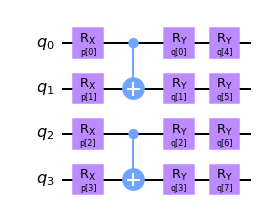

In [5]:
circuit = QuantumCircuit(n_qu)

params_data = ParameterVector('p', n_qu)
params_train = ParameterVector('q', n_qu*2)

for j in range(n_qu):
    #TODO: custome circuit, change gates
    circuit.rx(params_data[j], j)

for p in pairs:
    circuit.cx(p[0],p[1])

for j in range(n_qu*2):
    circuit.ry(params_train[j], j%n_qu)
circuit.draw()

In [6]:
sim = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(sim, shots=1024)

observable = Z ^ I ^ I ^ I

qnn_expectation = StateFn(observable, is_measurement=True) @ StateFn(circuit)

qnn = OpflowQNN(qnn_expectation,
                input_params=params_data,
                weight_params=params_train,
                exp_val=AerPauliExpectation(),
                gradient=Gradient(),
                quantum_instance=quantum_instance)

opt = SPSA(maxiter=100)
classifier = NeuralNetworkClassifier(qnn, optimizer=opt, loss='l2')

<ipython-input-6-0287251f93b4>:16: DeprecationWarning: The loss argument value "l2" is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the "squared_error" value.
  classifier = NeuralNetworkClassifier(qnn, optimizer=opt, loss='l2')


## Fitting the data

In [7]:
classifier.fit(x_train, y_train)

In [8]:
classifier.score(x_train, y_train)

0.8571428571428571

In [9]:
classifier.score(x_test, y_test)

0.7333333333333333

# Visualization of the results of classification with PCA

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
#normalizing data
scaler = StandardScaler()
scaler.fit(x_test)
test_visualization = scaler.transform(x_test)

#Applying pca
pca = PCA(n_components = 2)
pca.fit(test_visualization)
test_visualization = pca.transform(test_visualization)

## Visualization of the testing data with PCA

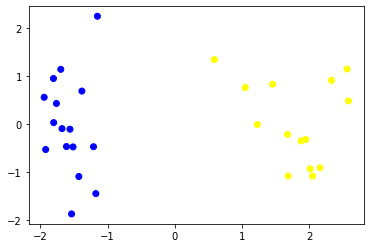

In [12]:
plt.scatter(test_visualization[:,0],test_visualization[:,1],
            color = np.array(["blue","yellow"])[np.array((y_test+1)/2, dtype = int)])

## Visualization of the mistakes (red) the Neural Network made

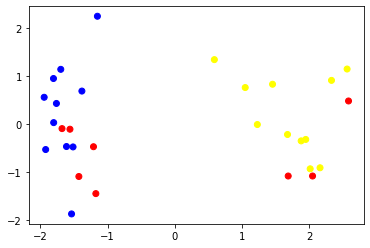

In [14]:
prediction = classifier.predict(x_test)[:,0]
error = np.array(abs(prediction-y_test)/2, dtype = int)

label_error = np.array((y_test+1)/2, dtype = int)
for i in range(len(error)):
    if error[i] == 1:
        label_error[i] = 2

plt.scatter(test_visualization[:,0],test_visualization[:,1],
            color = np.array(["blue","yellow","red"])[label_error])